In [1]:
import snowflake.connector
import sys
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import ast

In [2]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 100
pd.set_option('display.width', 2000)

In [3]:
plt.rcParams["figure.figsize"] = (10,8)
plt.style.use('seaborn-darkgrid')

In [4]:
con = snowflake.connector.connect(
    user="tliang@endpointclosing.com",
    account="endpoint",
    authenticator="externalbrowser",
    role="SNOWFLAKE_DATA_ENGINEERING",
    warehouse="DATAENGINEERING_WH"
)
cur = con.cursor()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [5]:
query = "SELECT * FROM LAKE.SALESFORCE.LEAD"
lead = cur.execute(query).fetch_pandas_all().reset_index()

#### PDL enrichment matching experiment

In [6]:
current_lead = lead[lead["IS_DELETED"] == False]

In [7]:
### list with full name, email, phone (both personal and work), city, state, 
search_colname = ["NAME","EMAIL","PHONE","MOBILE_PHONE","COMPANY","CITY","STATE"]

In [8]:
import itertools
search_col_subsets = []
for length in range(1,len(search_colname)+1):
    for subset in itertools.combinations(search_colname,length):
        search_col_subsets.append(list(subset))

search_col_subsets = [list(i) for i in {*[tuple(sorted(i)) for i in search_col_subsets]}]
search_col_subsets = sorted(search_col_subsets, key=lambda i: len(i))
search_col_subsets

[['STATE'],
 ['MOBILE_PHONE'],
 ['PHONE'],
 ['COMPANY'],
 ['NAME'],
 ['CITY'],
 ['EMAIL'],
 ['NAME', 'PHONE'],
 ['EMAIL', 'NAME'],
 ['MOBILE_PHONE', 'NAME'],
 ['PHONE', 'STATE'],
 ['MOBILE_PHONE', 'PHONE'],
 ['CITY', 'EMAIL'],
 ['COMPANY', 'STATE'],
 ['CITY', 'STATE'],
 ['CITY', 'MOBILE_PHONE'],
 ['COMPANY', 'EMAIL'],
 ['NAME', 'STATE'],
 ['CITY', 'COMPANY'],
 ['COMPANY', 'NAME'],
 ['CITY', 'NAME'],
 ['COMPANY', 'MOBILE_PHONE'],
 ['EMAIL', 'STATE'],
 ['COMPANY', 'PHONE'],
 ['EMAIL', 'MOBILE_PHONE'],
 ['CITY', 'PHONE'],
 ['MOBILE_PHONE', 'STATE'],
 ['EMAIL', 'PHONE'],
 ['EMAIL', 'MOBILE_PHONE', 'PHONE'],
 ['CITY', 'EMAIL', 'STATE'],
 ['COMPANY', 'NAME', 'STATE'],
 ['CITY', 'COMPANY', 'PHONE'],
 ['CITY', 'EMAIL', 'MOBILE_PHONE'],
 ['CITY', 'MOBILE_PHONE', 'STATE'],
 ['EMAIL', 'MOBILE_PHONE', 'NAME'],
 ['EMAIL', 'PHONE', 'STATE'],
 ['CITY', 'EMAIL', 'PHONE'],
 ['COMPANY', 'EMAIL', 'STATE'],
 ['COMPANY', 'PHONE', 'STATE'],
 ['COMPANY', 'EMAIL', 'MOBILE_PHONE'],
 ['CITY', 'NAME', 'PHONE'],


In [9]:
# for subset in search_col_subsets:
#     print(subset,": # of rows",len(current_lead[subset].dropna()))



In [10]:
current_lead[(current_lead["EMAIL"].notnull()) & (current_lead["MOBILE_PHONE"].isnull())]

,index,ID,IS_DELETED,MASTER_RECORD_ID,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,TITLE,COMPANY,STREET,CITY,STATE,POSTAL_CODE,COUNTRY,LATITUDE,LONGITUDE,GEOCODE_ACCURACY,PHONE,MOBILE_PHONE,FAX,EMAIL,WEBSITE,PHOTO_URL,DESCRIPTION,LEAD_SOURCE,STATUS,INDUSTRY,RATING,ANNUAL_REVENUE,NUMBER_OF_EMPLOYEES,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,IS_CONVERTED,CONVERTED_DATE,CONVERTED_ACCOUNT_ID,CONVERTED_CONTACT_ID,CONVERTED_OPPORTUNITY_ID,IS_UNREAD_BY_OWNER,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,DO_NOT_CALL,HAS_OPTED_OUT_OF_FAX,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,LAST_TRANSFER_DATE,JIGSAW,JIGSAW_CONTACT_ID,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,INDIVIDUAL_ID,POSTAL_CODE_C,MOST_RECENT_CAMPAIGN_C,ALTERNATE_EMAIL_C,APEX_PROCESSED_C,KNOCK_WEBHOOK_C,ALTERNATE_PHONE_C,TOTAL_SALES_C,BOOK_SIZE_SOW_PREFERRED_C,EMAIL_BOUNCED_C,EVENT_TYPE_C,IS_LEAD_C,AVERAGE_LIST_PRICE_C,FSBO_ADDRESS_C,FSBO_LISTING_PRICE_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,BROKERAGE_1_C,TOTAL_TRANSACTION_COUNT_C,COUNTY_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,DISQUALIFIED_NOTES_C,FA_LOYAL_LEAD_C,LS_SALES_C,TOTAL_LISTING_COUNT_C,PREFERRED_PROVIDER_BY_LISTING_COUNT_C,PRODUCT_DEMO_DATE_C,PREFERRED_ESCROW_COMPANY_C,ROLE_C,APP_DOWNLOAD_DATE_C,PREFERRED_TITLE_COMPANY_C,AGENT_MLS_ID_C,ORDER_ENTRY_NOTES_C,LEVEL_VETTING_C,LICENSE_NO_C,PARDOT_REASSIGNMENT_C,AGENT_ROLE_C,LISTING_PRICE_C,TOTAL_MODUS_TRANSACTION_COUNT_C,DIGITAL_TE_USER_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,LAST_MODIFIED_C,PREFERRED_PLATFORM_C,AVERAGE_CLOSE_PRICE_C,AVERAGE_TRANSACTION_AMOUNT_C,BS_COUNT_C,DISQUALIFIED_REASONS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_NUMBER_C,LEAD_RANKING_C,MATRIX_UNIQUE_ID_C,MEAL_TRACKER_C,PMXAGENT_ID_C,PREFERRED_ESCROW_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,PROPERTY_ADDRESS_C,REFERRAL_EMAIL_C,COMING_SOON_ADDRESS_C,KCA_C,_FIVETRAN_SYNCED,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,KNOCK_WEBHOOK_2021_C,DO_NOT_CONTACT_C,MOBILE_INDEXED_C,DEMO_SET_ON_C,DEMO_SCHEDULED_FOR_C
0,0,00Q8V00001M8Z9DUAV,False,None,Ahmad adham shikh bandar,Hasan,None,None,None,Hasan Ahmad adham shikh bandar,0121H000000zyueQAA,None,None,None,None,None,None,None,NaN,NaN,None,+967771262159,None,None,hasanahmadadhamshikhbandar@gmail.com,None,/services/images/photo/00Q8V00001M8Z9DUAV,None,Site Signup,New,None,None,NaN,NaN,00G1H000004ldrdUAA,False,False,None,None,None,None,True,2021-12-15 20:11:34-08:00,0051H000008sHbOQAU,2021-12-15 20:11:38-08:00,0051H000008sHbOQAU,2021-12-15 20:11:38-08:00,None,False,False,NaT,NaT,2021-12-16,None,None,None,NaT,None,None,7018V000000HE5eQAG,None,False,False,None,NaN,NaN,False,None,True,NaN,None,NaN,None,None,None,NaN,None,None,None,NaN,None,None,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,False,None,NaN,NaN,False,None,NaT,None,None,NaT,None,None,NaT,NaT,None,None,None,None,NaT,None,None,NaN,None,None,None,None,None,None,None,None,NaN,NaN,NaN,None,NaN,NaN,613573,None,None,NaN,None,NaN,None,None,NaN,NaN,False,None,None,None,None,None,False,2021-12-16 00:45:43.472000-08:00,False,None,None,None,True,None,None,None,None,NaT
2,2,00Q1H00001Fe5m0UAB,False,None,Chang,Tony,None,None,None,Tony Chang,0121H000000zyGvQAI,None,RE/MAX Prime Realty,2115 Joan Dr,Hacienda Heights,CA,91745,None,NaN,NaN,None,714-882-4900,None,None,tchang@castellanlaw.com,Non

In [11]:
# current_lead[(current_lead[search_col_subsets[10]].isna())&(current_lead[[e for e in search_colname if e not in search_col_subsets[10]]].notna().all(1))][[e for e in search_colname if e not in search_col_subsets[10]]]

In [12]:
for subset in search_col_subsets:
    exclude_list = [e for e in search_colname if e not in subset]
    print(subset," # of rows:",len(current_lead[(current_lead[subset].notna().all(1))&(current_lead[exclude_list].isna().all(1))]))

['STATE']  # of rows: 0
['MOBILE_PHONE']  # of rows: 0
['PHONE']  # of rows: 0
['COMPANY']  # of rows: 0
['NAME']  # of rows: 90
['CITY']  # of rows: 0
['EMAIL']  # of rows: 0
['NAME', 'PHONE']  # of rows: 0
['EMAIL', 'NAME']  # of rows: 2158
['MOBILE_PHONE', 'NAME']  # of rows: 683
['PHONE', 'STATE']  # of rows: 0
['MOBILE_PHONE', 'PHONE']  # of rows: 0
['CITY', 'EMAIL']  # of rows: 0
['COMPANY', 'STATE']  # of rows: 0
['CITY', 'STATE']  # of rows: 0
['CITY', 'MOBILE_PHONE']  # of rows: 0
['COMPANY', 'EMAIL']  # of rows: 0
['NAME', 'STATE']  # of rows: 17
['CITY', 'COMPANY']  # of rows: 0
['COMPANY', 'NAME']  # of rows: 90
['CITY', 'NAME']  # of rows: 0
['COMPANY', 'MOBILE_PHONE']  # of rows: 0
['EMAIL', 'STATE']  # of rows: 0
['COMPANY', 'PHONE']  # of rows: 0
['EMAIL', 'MOBILE_PHONE']  # of rows: 0
['CITY', 'PHONE']  # of rows: 0
['MOBILE_PHONE', 'STATE']  # of rows: 0
['EMAIL', 'PHONE']  # of rows: 0
['EMAIL', 'MOBILE_PHONE', 'PHONE']  # of rows: 0
['CITY', 'EMAIL', 'STATE']  # of 

In [13]:
for subset in search_col_subsets:
    exclude_list = [e for e in search_colname if e not in subset]
    if len(current_lead[(current_lead[subset].notna().all(1))&(current_lead[exclude_list].isna().all(1))]) != 0:
        print(subset," # of rows:",len(current_lead[(current_lead[subset].notna().all(1))&(current_lead[exclude_list].isna().all(1))]))

['NAME']  # of rows: 90
['EMAIL', 'NAME']  # of rows: 2158
['MOBILE_PHONE', 'NAME']  # of rows: 683
['NAME', 'STATE']  # of rows: 17
['COMPANY', 'NAME']  # of rows: 90
['COMPANY', 'NAME', 'STATE']  # of rows: 12
['EMAIL', 'MOBILE_PHONE', 'NAME']  # of rows: 962
['CITY', 'MOBILE_PHONE', 'NAME']  # of rows: 1
['MOBILE_PHONE', 'NAME', 'STATE']  # of rows: 225
['COMPANY', 'EMAIL', 'NAME']  # of rows: 177
['COMPANY', 'NAME', 'PHONE']  # of rows: 2
['EMAIL', 'NAME', 'STATE']  # of rows: 241
['COMPANY', 'MOBILE_PHONE', 'NAME']  # of rows: 22
['EMAIL', 'NAME', 'PHONE']  # of rows: 155
['CITY', 'NAME', 'STATE']  # of rows: 57
['COMPANY', 'MOBILE_PHONE', 'NAME', 'STATE']  # of rows: 108
['CITY', 'NAME', 'PHONE', 'STATE']  # of rows: 7488
['COMPANY', 'EMAIL', 'NAME', 'STATE']  # of rows: 247
['CITY', 'EMAIL', 'NAME', 'STATE']  # of rows: 101
['CITY', 'MOBILE_PHONE', 'NAME', 'STATE']  # of rows: 606
['COMPANY', 'EMAIL', 'NAME', 'PHONE']  # of rows: 13
['EMAIL', 'MOBILE_PHONE', 'NAME', 'PHONE']  # 

In [14]:
def lead_samplier(input_cols:list, df:pd.DataFrame, n_sample:int, random_state:int) -> pd.DataFrame:

    #specify the name of columns we are interested
    search_colname = ["NAME","EMAIL","PHONE","MOBILE_PHONE","COMPANY","CITY","STATE"]

    # based on the input columns, create the complement list
    exclude_list = [e for e in search_colname if e not in input_cols]

    # if exist, filter out records and sample n number of them that are all null in complement, but all not null in input list, else it returns empty list
    record_df = df[(df[input_cols].notna().all(1))&(df[exclude_list].isna().all(1))]
    if len(record_df) != 0:
        sample_df = df[(df[input_cols].notna().all(1))&(df[exclude_list].isna().all(1))][["ID"] + search_colname].fillna("").sample(n= min(n_sample, len(record_df)), random_state= random_state).reset_index(drop = True)
    else:
        sample_df = pd.DataFrame()
    return sample_df
    

In [15]:
# fill in the params based on the input column

# using the params to retrieve the data from pdl
## if 200 (exist), then merge the record to existing row
## if 404 (not exist), then pass

# after all rows are searched in pdl
## calculate how many records are retrieved
## for those which have record retrieved, how many columns (paramas) are not null
## print out input records, and also the related records that retrived from pdl


In [16]:
def pdl_matcher(input_df):

    if len(input_df) == 0:
        return input_df

    else:

        input_df['NAME'] = [i.lower() for i in input_df["NAME"]]

        API_KEY = "ce8e4e0d9b819994f79cf0603d17b4997c46114d328d747f295b6f21f89deacd"
        pdl_url= "https://api.peopledatalabs.com/v5/person/enrich"

        pdl_response = []
        for i in range(len(input_df)):
            params = {
                "api_key": API_KEY,
                "name": [input_df.loc[i,"NAME"]], 
                "email":[input_df.loc[i,"EMAIL"]],
                "phone":[input_df.loc[i,"PHONE"]+ input_df.loc[i,"MOBILE_PHONE"]],
                "company":[input_df.loc[i,"COMPANY"]],  
                "location": [input_df.loc[i,"CITY"]+ input_df.loc[i,"STATE"]],
                "min_likelihood": 1
                "include_if_matched": True
                }
        
            json_response = requests.get(pdl_url,  params=params).json()

            # if json_response["status"] == 200:

            #     print(input_df.loc[i,"NAME"]," successfully enriched profile with pdl data")

            # else:
            
            #     print(input_df.loc[i,"NAME"], "Enrichment unsuccessful. See error and try again.")
            #     print("error:", json_response)

            pdl_response.append(json_response)
        
        input_df['PDL_RESPONSE'] = pdl_response

        output_df = pd.concat([input_df.iloc[:,:-1], pd.json_normalize(input_df["PDL_RESPONSE"])],axis= 1)
    
        return output_df

In [17]:
# for subset in lists
# use subset call lead_sampler function, output sample_df
# use sample_df to call pdl_matcher, output pdl_output
# add subset information to pdl_output, concat into overall_df
# output the overall_df

def pdl_parser(subsets_list:list, lead_df:pd.DataFrame, n_sample:int)-> pd.DataFrame:

    # API limit is 100 record/ min
    # using the limit to calculate sleep time
    limit_time = (60/100) * (n_sample * 1.1)

    output_df = pd.DataFrame()

    for subset in subsets_list:
        sample_df = lead_samplier(subset,lead_df, n_sample=n_sample, random_state=1)
        sample_df_pdl = pdl_matcher(sample_df)
        if len(sample_df_pdl) != 0:
            sample_df_pdl["SEARCH_SUBSET"] =str(subset)
    
        output_df = pd.concat([output_df,sample_df_pdl], ignore_index= True)

        time.sleep(limit_time)

    return output_df

    


In [19]:
test_search_col_subsets = search_col_subsets[125:]

In [20]:
# test_pdl_overall_df = pdl_parser(test_search_col_subsets,current_lead)

In [21]:
# test_pdl_overall_df

In [22]:
#! be aware of running this code
# pdl_overall_df = pdl_parser(search_col_subsets,current_lead)

In [23]:
# pdl_overall_df.to_csv("pdl_overall_df.csv")

In [24]:
# pdl_overall_df.dtypes

#### PDL result analyses

In [25]:
import_pdl_overall_df = pd.read_csv("../data/pdl_data/pdl_overall_df.csv", index_col = 0)

In [26]:
import_pdl_overall_df.head()

,ID,NAME,EMAIL,PHONE,MOBILE_PHONE,COMPANY,CITY,STATE,status,error.type,error.message,SEARCH_SUBSET,likelihood,dataset_version,data.id,data.full_name,data.first_name,data.middle_initial,data.middle_name,data.last_initial,data.last_name,data.gender,data.birth_year,data.birth_date,data.linkedin_url,data.linkedin_username,data.linkedin_id,data.facebook_url,data.facebook_username,data.facebook_id,data.twitter_url,data.twitter_username,data.github_url,data.github_username,data.work_email,data.personal_emails,data.mobile_phone,data.industry,data.job_title,data.job_title_role,data.job_title_sub_role,data.job_title_levels,data.job_company_id,data.job_company_name,data.job_company_website,data.job_company_size,data.job_company_founded,data.job_company_industry,data.job_company_linkedin_url,data.job_company_linkedin_id,data.job_company_facebook_url,data.job_company_twitter_url,data.job_company_location_name,data.job_company_location_locality,data.job_company_location_metro,data.job_company_location_region,data.job_company_location_geo,data.job_company_location_street_address,data.job_company_location_address_line_2,data.job_company_location_postal_code,data.job_company_location_country,data.job_company_location_continent,data.job_last_updated,data.job_start_date,data.location_name,data.location_locality,data.location_metro,data.location_region,data.location_country,data.location_continent,data.location_street_address,data.location_address_line_2,data.location_postal_code,data.location_geo,data.location_last_updated,data.phone_numbers,data.emails,data.interests,data.skills,data.location_names,data.regions,data.countries,data.street_addresses,data.experience,data.education,data.profiles,data.version_status.status,data.version_status.contains,data.version_status.previous_version,data.version_status.current_version
0,00Q1H00001J1qJxUAJ,jack combs,NaN,NaN,NaN,NaN,NaN,NaN,404,not_found,No records were found matching your request,['NAME'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00Q1H00001FdNk3UAF,jay pearson,NaN,NaN,NaN,NaN,NaN,NaN,404,not_found,No records were found matching your request,['NAME'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00Q1H00001JeYclUAF,elena peters,NaN,NaN,NaN,NaN,NaN,NaN,404,not_found,No records were found matching your request,['NAME'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00Q1H00001J1qJpUAJ,liz majam,NaN,NaN,NaN,NaN,NaN,NaN,404,not_found,No records were found matching your request,['NAME'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00Q1H00001J1qJwUAJ,jessica berry,NaN,NaN,NaN,NaN,NaN,NaN,404,not_found,No records were found matching your request,['NAME'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [27]:
import_pdl_overall_df.dtypes

ID                                           object
NAME                                         object
EMAIL                                        object
PHONE                                        object
MOBILE_PHONE                                 object
COMPANY                                      object
CITY                                         object
STATE                                        object
status                                        int64
error.type                                   object
error.message                                object
SEARCH_SUBSET                                object
likelihood                                  float64
dataset_version                              object
data.id                                      object
data.full_name                               object
data.first_name                              object
data.middle_initial                          object
data.middle_name                             object
data.last_in

In [28]:
import_pdl_overall_df["status"].value_counts()

200    120
404     58
Name: status, dtype: int64

In [29]:
import_pdl_overall_df.query("status == 200")['likelihood'].value_counts()

10.0    63
9.0     18
8.0      9
4.0      7
7.0      6
5.0      6
3.0      6
2.0      5
Name: likelihood, dtype: int64

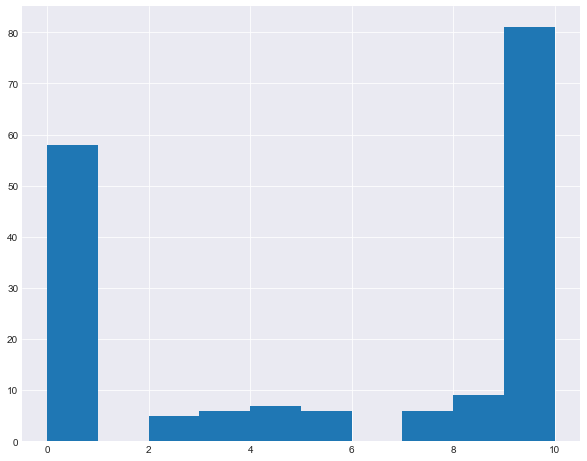

In [30]:
import_pdl_overall_df['likelihood'].fillna(0).hist()
plt.show()

In [31]:
import_pdl_overall_df.groupby("SEARCH_SUBSET")["status"].value_counts(normalize= True).unstack().reset_index().iloc[:,:-1]

status,SEARCH_SUBSET,200
0,"['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', '...",0.80
1,"['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', '...",1.00
2,"['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', '...",1.00
3,"['CITY', 'COMPANY', 'EMAIL', 'NAME', 'PHONE', ...",0.80
4,"['CITY', 'COMPANY', 'EMAIL', 'NAME', 'STATE']",0.60
5,"['CITY', 'COMPANY', 'MOBILE_PHONE', 'NAME', 'P...",0.60
6,"['CITY', 'COMPANY', 'MOBILE_PHONE', 'NAME', 'S...",0.60
7,"['CITY', 'COMPANY', 'NAME', 'PHONE', 'STATE']",0.80
8,"['CITY', 'COMPANY', 'NAME', 'STATE']",0.40
9,"['CITY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'PHO...",0.40


In [32]:
import_pdl_overall_df.groupby("SEARCH_SUBSET")["likelihood"].mean()

SEARCH_SUBSET
['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'PHONE', 'STATE']     8.500000
['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'STATE']              8.800000
['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', 'NAME']                       9.000000
['CITY', 'COMPANY', 'EMAIL', 'NAME', 'PHONE', 'STATE']                     9.750000
['CITY', 'COMPANY', 'EMAIL', 'NAME', 'STATE']                              9.666667
['CITY', 'COMPANY', 'MOBILE_PHONE', 'NAME', 'PHONE', 'STATE']              6.666667
['CITY', 'COMPANY', 'MOBILE_PHONE', 'NAME', 'STATE']                      10.000000
['CITY', 'COMPANY', 'NAME', 'PHONE', 'STATE']                              8.750000
['CITY', 'COMPANY', 'NAME', 'STATE']                                       9.500000
['CITY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'PHONE', 'STATE']               10.000000
['CITY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'STATE']                         9.250000
['CITY', 'EMAIL', 'NAME', 'PHONE', 'STATE']                   

In [33]:
skim_cols  = ['NAME',"data.full_name",
            "EMAIL","data.emails",
            "PHONE","MOBILE_PHONE",'data.phone_numbers','data.mobile_phone',
            "COMPANY",'data.job_company_name',
            "CITY", "data.location_locality",
            "STATE", "data.location_region"
                ]

In [34]:
search_col_subsets[110]

['CITY', 'EMAIL', 'MOBILE_PHONE', 'PHONE', 'STATE']

In [35]:
import_pdl_overall_df[import_pdl_overall_df["SEARCH_SUBSET"] == str(search_col_subsets[110])][skim_cols]

,NAME,data.full_name,EMAIL,data.emails,PHONE,MOBILE_PHONE,data.phone_numbers,data.mobile_phone,COMPANY,data.job_company_name,CITY,data.location_locality,STATE,data.location_region


In [36]:
str(search_col_subsets[0])

"['STATE']"

#### Retrieve data from top 5 subsets with largest samples

In [37]:
subset_record_count = pd.DataFrame(columns= ["subsets","excluded","nrows"])
for i in range(len(search_col_subsets)):
    subset_record_count.loc[i,"subsets"] = str(search_col_subsets[i])
    subset_record_count.loc[i,"excluded"] = str([e for e in search_colname if e not in search_col_subsets[i]])
    subset_record_count.loc[i,"nrows"] = len(current_lead[(current_lead[search_col_subsets[i]].notna().all(1))&(current_lead[[e for e in search_colname if e not in search_col_subsets[i]]].isna().all(1))])

In [38]:
subset_record_count.sort_values(by="nrows", ascending=False)

,subsets,excluded,nrows
126,"['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', '...",[],248574
119,"['CITY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'PHO...",['COMPANY'],112244
120,"['CITY', 'COMPANY', 'EMAIL', 'NAME', 'PHONE', ...",['MOBILE_PHONE'],44655
89,"['CITY', 'COMPANY', 'NAME', 'STATE']","['EMAIL', 'PHONE', 'MOBILE_PHONE']",44069
121,"['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', '...",['PHONE'],38783
...,...,...,...
38,"['COMPANY', 'PHONE', 'STATE']","['NAME', 'EMAIL', 'MOBILE_PHONE', 'CITY']",0
37,"['COMPANY', 'EMAIL', 'STATE']","['NAME', 'PHONE', 'MOBILE_PHONE', 'CITY']",0
36,"['CITY', 'EMAIL', 'PHONE']","['NAME', 'MOBILE_PHONE', 'COMPANY', 'STATE']",0
35,"['EMAIL', 'PHONE', 'STATE']","['NAME', 'MOBILE_PHONE', 'COMPANY', 'CITY']",0


In [39]:
top5_subsets = [ast.literal_eval(i) for i in subset_record_count.loc[subset_record_count.sort_values(by="nrows", ascending=False).head(5).index,:]['subsets']]
top5_subsets

[['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'PHONE', 'STATE'],
 ['CITY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'PHONE', 'STATE'],
 ['CITY', 'COMPANY', 'EMAIL', 'NAME', 'PHONE', 'STATE'],
 ['CITY', 'COMPANY', 'NAME', 'STATE'],
 ['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'STATE']]

In [40]:
# pdl_top5_df = pdl_parser(subsets_list = top5_subsets, lead_df = current_lead, n_sample = 100)

In [41]:
# pdl_top5_df.to_csv("pdl_top5_df.csv")

In [42]:
import_pdl_top5_df = pd.read_csv("../data/pdl_data/pdl_top5_df.csv", index_col = 0)

In [43]:
import_pdl_top5_df.head()

,ID,NAME,EMAIL,PHONE,MOBILE_PHONE,COMPANY,CITY,STATE,status,likelihood,dataset_version,data.id,data.full_name,data.first_name,data.middle_initial,data.middle_name,data.last_initial,data.last_name,data.gender,data.birth_year,data.birth_date,data.linkedin_url,data.linkedin_username,data.linkedin_id,data.facebook_url,data.facebook_username,data.facebook_id,data.twitter_url,data.twitter_username,data.github_url,data.github_username,data.work_email,data.personal_emails,data.mobile_phone,data.industry,data.job_title,data.job_title_role,data.job_title_sub_role,data.job_title_levels,data.job_company_id,data.job_company_name,data.job_company_website,data.job_company_size,data.job_company_founded,data.job_company_industry,data.job_company_linkedin_url,data.job_company_linkedin_id,data.job_company_facebook_url,data.job_company_twitter_url,data.job_company_location_name,data.job_company_location_locality,data.job_company_location_metro,data.job_company_location_region,data.job_company_location_geo,data.job_company_location_street_address,data.job_company_location_address_line_2,data.job_company_location_postal_code,data.job_company_location_country,data.job_company_location_continent,data.job_last_updated,data.job_start_date,data.location_name,data.location_locality,data.location_metro,data.location_region,data.location_country,data.location_continent,data.location_street_address,data.location_address_line_2,data.location_postal_code,data.location_geo,data.location_last_updated,data.phone_numbers,data.emails,data.interests,data.skills,data.location_names,data.regions,data.countries,data.street_addresses,data.experience,data.education,data.profiles,data.version_status.status,data.version_status.contains,data.version_status.previous_version,data.version_status.current_version,error.type,error.message,SEARCH_SUBSET
0,00Q1H00001Fe5IPUAZ,susan sung,susansung@earthlink.net,562-924-1411,(562) 714-4600,Ace Realty,Artesia,CA,200,10.0,v18.0,dUdMvchJwxAXjyogLyEFTQ_0000,susan sung,susan,NaN,NaN,s,sung,female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[{'address': 'susansung@earthlink.net', 'type'...",[],[],[],[],[],[],"[{'company': {'name': 'earthlink', 'size': '20...",[],[],unchanged,[],17.0,18.0,NaN,NaN,"['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', '..."
1,00Q1H00001Fda5HUAR,annie clougherty,annie.clougherty@compass.com,949-438-4340,(949) 375-3037,Compass,Newport Beach,CA,200,10.0,v18.0,JVrD1gm8ytfErB6v3is6YQ_0000,annie clougherty,annie,NaN,NaN,c,clougherty,female,NaN,NaN,linkedin.com/in/annie-clougherty-43945b6,annie-clougherty-43945b6,19034541.0,facebook.com/annie.riggsclougherty,annie.riggsclougherty,1.056948e+09,NaN,NaN,NaN,NaN,NaN,[],NaN,real estate,leader of the ac team,NaN,NaN,['manager'],compass-group,compass group,compass-group.com,10001+,1941.0,food & beverages,linkedin.com/company/compass-group,852267.0,facebook.com/compassgroupuki,twitter.com/compassgroupuk,"chertsey, surrey, united kingdom",chertsey,NaN,surrey,"51.38,-0.50",NaN,NaN,NaN,united kingdom,europe,2022-03-09,2017-10,"newport beach, california, united states",newport beach,"los angeles, california",california,united states,north america,NaN,NaN,NaN,"33.61,-117.92",2022-03-09,[],"[{'address': 'annie.clougherty@compass.com', '...","['paddle boarding', 'scuba diving']","['real estate', 'investment properties', 'shor...","['newport beach, california, united states', '...","['california, united states']",['united states'],[],"[{'company': {'name': ""t's restaurant"", 'size'...","[{'school': {'name': 'el toro high school', 't...","[{'network': 'linkedin', 'id': '19034541', 'ur...",updated,[],17.0,18.0,NaN,NaN,"['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', '..."
2,00Q8V00001M6TqRUAV,edward anthony rhem,edrhem-02@twc.com,(512) 456-0582,(512) 456-0582,Edward Anthony Rhem,Leander,TX,200,4.0,v18.0,I4XetI5uM3DZNp7dBI9eog_

In [44]:
import_pdl_top5_df["status"].value_counts()

200    348
404    152
Name: status, dtype: int64

In [45]:
import_pdl_top5_df["status"].value_counts(normalize= True)

200    0.696
404    0.304
Name: status, dtype: float64

In [46]:
import_pdl_top5_df.query("status == 200")['likelihood'].value_counts()

10.0    184
9.0      49
8.0      28
6.0      21
7.0      19
4.0      13
1.0      13
3.0       9
5.0       7
2.0       5
Name: likelihood, dtype: int64

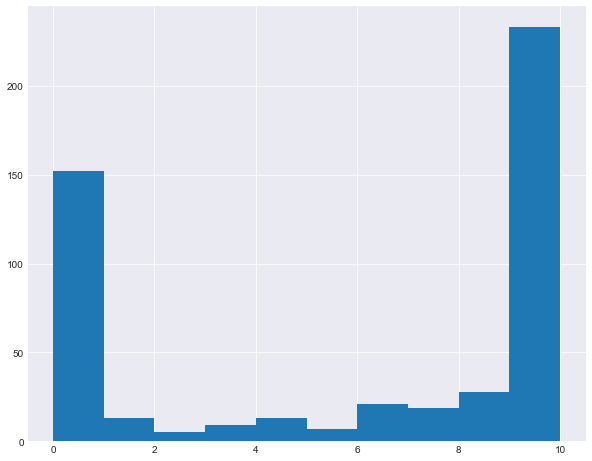

In [47]:
import_pdl_top5_df['likelihood'].fillna(0).hist()
plt.show()

In [48]:
import_pdl_top5_df.groupby("SEARCH_SUBSET")["status"].value_counts(normalize= True).unstack().reset_index().iloc[:,:-1].values

array([["['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'PHONE', 'STATE']",
        0.73],
       ["['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'STATE']",
        0.91],
       ["['CITY', 'COMPANY', 'EMAIL', 'NAME', 'PHONE', 'STATE']", 0.86],
       ["['CITY', 'COMPANY', 'NAME', 'PHONE', 'STATE']", 0.7],
       ["['CITY', 'COMPANY', 'NAME', 'STATE']", 0.28]], dtype=object)

In [49]:
import_pdl_top5_df.fillna(0).groupby("SEARCH_SUBSET")["likelihood"].mean()

SEARCH_SUBSET
['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'PHONE', 'STATE']    6.40
['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'STATE']             8.28
['CITY', 'COMPANY', 'EMAIL', 'NAME', 'PHONE', 'STATE']                    7.34
['CITY', 'COMPANY', 'NAME', 'PHONE', 'STATE']                             4.54
['CITY', 'COMPANY', 'NAME', 'STATE']                                      2.45
Name: likelihood, dtype: float64

In [50]:
import_pdl_top5_df.groupby("SEARCH_SUBSET")["likelihood"].mean()

SEARCH_SUBSET
['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'PHONE', 'STATE']    8.767123
['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'STATE']             9.098901
['CITY', 'COMPANY', 'EMAIL', 'NAME', 'PHONE', 'STATE']                    8.534884
['CITY', 'COMPANY', 'NAME', 'PHONE', 'STATE']                             6.485714
['CITY', 'COMPANY', 'NAME', 'STATE']                                      8.750000
Name: likelihood, dtype: float64

In [51]:
import_pdl_top5_df[import_pdl_top5_df["SEARCH_SUBSET"] == str(top5_subsets[1])][skim_cols].head()

,NAME,data.full_name,EMAIL,data.emails,PHONE,MOBILE_PHONE,data.phone_numbers,data.mobile_phone,COMPANY,data.job_company_name,CITY,data.location_locality,STATE,data.location_region


In [52]:
import_pdl_top5_df.head()

,ID,NAME,EMAIL,PHONE,MOBILE_PHONE,COMPANY,CITY,STATE,status,likelihood,dataset_version,data.id,data.full_name,data.first_name,data.middle_initial,data.middle_name,data.last_initial,data.last_name,data.gender,data.birth_year,data.birth_date,data.linkedin_url,data.linkedin_username,data.linkedin_id,data.facebook_url,data.facebook_username,data.facebook_id,data.twitter_url,data.twitter_username,data.github_url,data.github_username,data.work_email,data.personal_emails,data.mobile_phone,data.industry,data.job_title,data.job_title_role,data.job_title_sub_role,data.job_title_levels,data.job_company_id,data.job_company_name,data.job_company_website,data.job_company_size,data.job_company_founded,data.job_company_industry,data.job_company_linkedin_url,data.job_company_linkedin_id,data.job_company_facebook_url,data.job_company_twitter_url,data.job_company_location_name,data.job_company_location_locality,data.job_company_location_metro,data.job_company_location_region,data.job_company_location_geo,data.job_company_location_street_address,data.job_company_location_address_line_2,data.job_company_location_postal_code,data.job_company_location_country,data.job_company_location_continent,data.job_last_updated,data.job_start_date,data.location_name,data.location_locality,data.location_metro,data.location_region,data.location_country,data.location_continent,data.location_street_address,data.location_address_line_2,data.location_postal_code,data.location_geo,data.location_last_updated,data.phone_numbers,data.emails,data.interests,data.skills,data.location_names,data.regions,data.countries,data.street_addresses,data.experience,data.education,data.profiles,data.version_status.status,data.version_status.contains,data.version_status.previous_version,data.version_status.current_version,error.type,error.message,SEARCH_SUBSET
0,00Q1H00001Fe5IPUAZ,susan sung,susansung@earthlink.net,562-924-1411,(562) 714-4600,Ace Realty,Artesia,CA,200,10.0,v18.0,dUdMvchJwxAXjyogLyEFTQ_0000,susan sung,susan,NaN,NaN,s,sung,female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[{'address': 'susansung@earthlink.net', 'type'...",[],[],[],[],[],[],"[{'company': {'name': 'earthlink', 'size': '20...",[],[],unchanged,[],17.0,18.0,NaN,NaN,"['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', '..."
1,00Q1H00001Fda5HUAR,annie clougherty,annie.clougherty@compass.com,949-438-4340,(949) 375-3037,Compass,Newport Beach,CA,200,10.0,v18.0,JVrD1gm8ytfErB6v3is6YQ_0000,annie clougherty,annie,NaN,NaN,c,clougherty,female,NaN,NaN,linkedin.com/in/annie-clougherty-43945b6,annie-clougherty-43945b6,19034541.0,facebook.com/annie.riggsclougherty,annie.riggsclougherty,1.056948e+09,NaN,NaN,NaN,NaN,NaN,[],NaN,real estate,leader of the ac team,NaN,NaN,['manager'],compass-group,compass group,compass-group.com,10001+,1941.0,food & beverages,linkedin.com/company/compass-group,852267.0,facebook.com/compassgroupuki,twitter.com/compassgroupuk,"chertsey, surrey, united kingdom",chertsey,NaN,surrey,"51.38,-0.50",NaN,NaN,NaN,united kingdom,europe,2022-03-09,2017-10,"newport beach, california, united states",newport beach,"los angeles, california",california,united states,north america,NaN,NaN,NaN,"33.61,-117.92",2022-03-09,[],"[{'address': 'annie.clougherty@compass.com', '...","['paddle boarding', 'scuba diving']","['real estate', 'investment properties', 'shor...","['newport beach, california, united states', '...","['california, united states']",['united states'],[],"[{'company': {'name': ""t's restaurant"", 'size'...","[{'school': {'name': 'el toro high school', 't...","[{'network': 'linkedin', 'id': '19034541', 'ur...",updated,[],17.0,18.0,NaN,NaN,"['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', '..."
2,00Q8V00001M6TqRUAV,edward anthony rhem,edrhem-02@twc.com,(512) 456-0582,(512) 456-0582,Edward Anthony Rhem,Leander,TX,200,4.0,v18.0,I4XetI5uM3DZNp7dBI9eog_

In [53]:
import_pdl_top5_df.groupby("SEARCH_SUBSET").apply(lambda x: x.notnull().mean())[["data.mobile_phone"]]

,data.mobile_phone
SEARCH_SUBSET,
"['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'PHONE', 'STATE']",0.22
"['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'STATE']",0.49
"['CITY', 'COMPANY', 'EMAIL', 'NAME', 'PHONE', 'STATE']",0.21
"['CITY', 'COMPANY', 'NAME', 'PHONE', 'STATE']",0.24
"['CITY', 'COMPANY', 'NAME', 'STATE']",0.09


In [54]:
import_pdl_top5_df.groupby("SEARCH_SUBSET").apply(lambda x: x.notnull().mean())

,ID,NAME,EMAIL,PHONE,MOBILE_PHONE,COMPANY,CITY,STATE,status,likelihood,dataset_version,data.id,data.full_name,data.first_name,data.middle_initial,data.middle_name,data.last_initial,data.last_name,data.gender,data.birth_year,data.birth_date,data.linkedin_url,data.linkedin_username,data.linkedin_id,data.facebook_url,data.facebook_username,data.facebook_id,data.twitter_url,data.twitter_username,data.github_url,data.github_username,data.work_email,data.personal_emails,data.mobile_phone,data.industry,data.job_title,data.job_title_role,data.job_title_sub_role,data.job_title_levels,data.job_company_id,data.job_company_name,data.job_company_website,data.job_company_size,data.job_company_founded,data.job_company_industry,data.job_company_linkedin_url,data.job_company_linkedin_id,data.job_company_facebook_url,data.job_company_twitter_url,data.job_company_location_name,data.job_company_location_locality,data.job_company_location_metro,data.job_company_location_region,data.job_company_location_geo,data.job_company_location_street_address,data.job_company_location_address_line_2,data.job_company_location_postal_code,data.job_company_location_country,data.job_company_location_continent,data.job_last_updated,data.job_start_date,data.location_name,data.location_locality,data.location_metro,data.location_region,data.location_country,data.location_continent,data.location_street_address,data.location_address_line_2,data.location_postal_code,data.location_geo,data.location_last_updated,data.phone_numbers,data.emails,data.interests,data.skills,data.location_names,data.regions,data.countries,data.street_addresses,data.experience,data.education,data.profiles,data.version_status.status,data.version_status.contains,data.version_status.previous_version,data.version_status.current_version,error.type,error.message,SEARCH_SUBSET
SEARCH_SUBSET,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'PHONE', 'STATE']",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.73,0.73,0.73,0.73,0.73,0.31,0.16,0.73,0.73,0.66,0.22,0.12,0.36,0.36,0.36,0.22,0.22,0.24,0.03,0.03,0.0,0.0,0.07,0.73,0.22,0.33,0.32,0.26,0.20,0.73,0.23,0.31,0.23,0.23,0.21,0.23,0.23,0.23,0.09,0.13,0.22,0.21,0.19,0.22,0.21,0.17,0.08,0.18,0.22,0.22,0.31,0.25,0.60,0.57,0.54,0.59,0.60,0.60,0.31,0.06,0.34,0.58,0.46,0.73,0.73,0.73,0.73,0.73,0.73,0.73,0.73,0.73,0.73,0.73,0.73,0.73,0.73,0.73,0.27,0.27,1.0
"['CITY', 'COMPANY', 'EMAIL', 'MOBILE_PHONE', 'NAME', 'STATE']",1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.91,0.91,0.91,0.91,0.91,0.36,0.16,0.91,0.91,0.82,0.40,0.19,0.34,0.34,0.31,0.45,0.45,0.46,0.05,0.05,0.0,0.0,0.07,0.91,0.49,0.29,0.35,0.31,0.22,0.91,0.22,0.35,0.20,0.22,0.17,0.21,0.22,0.21,0.07,0.09,0.20,0.19,0.20,0.20,0.20,0.14,0.03,0.16,0.20,0.20,0.29,0.29,0.77,0.67,0.61,0.71,0.77,0.77,0.42,0.05,0.44,0.67,0.54,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.09,0.09,1.0
"['CITY', 'COMPANY', 'EMAIL', 'NAME', 'PHONE', 'STATE']",1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.86,0.86,0.86,0.86,0.86,0.31,0.13,0.86,0.86,0.76,0.34,0.19,0.44,0.44,0.42,0.21,0.21,0.23,0.10,0.10,0.0,0.0,0.08,0.86,0.21,0.40,0.35,0.27,0.14,0.86,0.25,0.35,0.25,0.25,0.21,0.25,0.25,0.25,0.09,0.09,0.24,0.23,0.22,0.24,0.22,0.20,0.07,0.23,0.24,0.24,0.35,0.27,0.74,0.67,0.67,0.69,0.74,0.74,0.41,0.10,0.43,0.67,0.60,0.86,0.86,0.86,0.86,0.86,0.86,0.86,0.86,0.86,0.86,0.86,0.86,0.86,0.86,0.86,0.14,0.14,1.0
"['CITY', 'COMPANY', 'NAME', 'PHONE', 'STATE']",1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.70,0.70,0.70,0.70,0.70,0.35,0.19,0.70,0.70,0.59,0.27,0.15,0.41,0.41,0.41,0.17,0.17,0.22,0.04,0.04,0.0,0.0,0.09,0.70,0.24,0.41,0.39,0.20,0.09,0.70,0.24,0.37,0.21,0.24,0.16,0.24,0.24,0.23,0.11,0.10,0.23,0.21,0.19,0.21,0.21,0.18,0.09,0.19,0.23,0.23,0.38,0.29,0.64,0.61,0.56,0.63,0.64,0.64,0.37,0.09,0.38,0.60,0.56,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.30,0.30,1.0
"['CITY', 'COMPANY', 'NAME', 'STATE']",1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0

In [55]:
import_pdl_top5_df.notna().sum() / len(import_pdl_top5_df)

ID                                          1.000
NAME                                        1.000
EMAIL                                       0.600
PHONE                                       0.600
MOBILE_PHONE                                0.400
COMPANY                                     1.000
CITY                                        1.000
STATE                                       1.000
status                                      1.000
likelihood                                  0.696
dataset_version                             0.696
data.id                                     0.696
data.full_name                              0.696
data.first_name                             0.696
data.middle_initial                         0.280
data.middle_name                            0.130
data.last_initial                           0.696
data.last_name                              0.696
data.gender                                 0.616
data.birth_year                             0.258


In [56]:
import_pdl_overall_df.notna().sum() / len(import_pdl_overall_df)

ID                                          1.000000
NAME                                        1.000000
EMAIL                                       0.601124
PHONE                                       0.337079
MOBILE_PHONE                                0.516854
COMPANY                                     0.556180
CITY                                        0.393258
STATE                                       0.640449
status                                      1.000000
error.type                                  0.325843
error.message                               0.325843
SEARCH_SUBSET                               1.000000
likelihood                                  0.674157
dataset_version                             0.674157
data.id                                     0.674157
data.full_name                              0.674157
data.first_name                             0.674157
data.middle_initial                         0.258427
data.middle_name                            0.

In [57]:
# import_pdl_overall_df.query("status = '200'").notna().sum() / len(import_pdl_overall_df.query("status = '200'"))

In [58]:
import_pdl_top5_df[import_pdl_top5_df["STATE"].apply(lambda x: str(x).lower().startswith("wa"))].notna().sum() / len(import_pdl_top5_df[import_pdl_top5_df["STATE"].apply(lambda x: str(x).lower().startswith("wa"))])

ID                                          1.000000
NAME                                        1.000000
EMAIL                                       0.833333
PHONE                                       0.166667
MOBILE_PHONE                                0.766667
COMPANY                                     1.000000
CITY                                        1.000000
STATE                                       1.000000
status                                      1.000000
likelihood                                  0.866667
dataset_version                             0.866667
data.id                                     0.866667
data.full_name                              0.866667
data.first_name                             0.866667
data.middle_initial                         0.333333
data.middle_name                            0.133333
data.last_initial                           0.866667
data.last_name                              0.866667
data.gender                                 0.

In [59]:
import_pdl_top5_df[import_pdl_top5_df["STATE"].apply(lambda x: str(x).lower().startswith("wa"))]["status"].value_counts()

200    26
404     4
Name: status, dtype: int64

In [60]:
import_pdl_top5_df[import_pdl_top5_df["STATE"].apply(lambda x: str(x).lower().startswith("wa"))].head()

,ID,NAME,EMAIL,PHONE,MOBILE_PHONE,COMPANY,CITY,STATE,status,likelihood,dataset_version,data.id,data.full_name,data.first_name,data.middle_initial,data.middle_name,data.last_initial,data.last_name,data.gender,data.birth_year,data.birth_date,data.linkedin_url,data.linkedin_username,data.linkedin_id,data.facebook_url,data.facebook_username,data.facebook_id,data.twitter_url,data.twitter_username,data.github_url,data.github_username,data.work_email,data.personal_emails,data.mobile_phone,data.industry,data.job_title,data.job_title_role,data.job_title_sub_role,data.job_title_levels,data.job_company_id,data.job_company_name,data.job_company_website,data.job_company_size,data.job_company_founded,data.job_company_industry,data.job_company_linkedin_url,data.job_company_linkedin_id,data.job_company_facebook_url,data.job_company_twitter_url,data.job_company_location_name,data.job_company_location_locality,data.job_company_location_metro,data.job_company_location_region,data.job_company_location_geo,data.job_company_location_street_address,data.job_company_location_address_line_2,data.job_company_location_postal_code,data.job_company_location_country,data.job_company_location_continent,data.job_last_updated,data.job_start_date,data.location_name,data.location_locality,data.location_metro,data.location_region,data.location_country,data.location_continent,data.location_street_address,data.location_address_line_2,data.location_postal_code,data.location_geo,data.location_last_updated,data.phone_numbers,data.emails,data.interests,data.skills,data.location_names,data.regions,data.countries,data.street_addresses,data.experience,data.education,data.profiles,data.version_status.status,data.version_status.contains,data.version_status.previous_version,data.version_status.current_version,error.type,error.message,SEARCH_SUBSET
121,00Q1H00001FdMw4UAF,tara menard,tmenard@gatewayre.com,(253) 904-1500,NaN,Gateway Real Estate,Puyallup,WA,200,9.0,v18.0,qfNiyeqLbvd87SjtXAN2hA_0000,tara menard,tara,NaN,NaN,m,menard,female,NaN,NaN,linkedin.com/in/tara-menard-b5aa851a2,tara-menard-b5aa851a2,796936246.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],NaN,real estate,real estate broker,finance,NaN,[],gateway-real-estate,gateway real estate,gatewayre.com,51-200,NaN,real estate,linkedin.com/company/gateway-real-estate,1361227.0,facebook.com/gatewayre,NaN,"puyallup, washington, united states",puyallup,"seattle, washington",washington,"47.18,-122.29",850 39th avenue southwest,NaN,98373,united states,north america,2022-03-03,2019-09,"puyallup, washington, united states",puyallup,"seattle, washington",washington,united states,north america,NaN,NaN,NaN,"47.18,-122.29",2022-03-03,[],[],[],[],"['puyallup, washington, united states']","['washington, united states']",['united states'],[],"[{'company': {'name': 'gateway real estate', '...",[],"[{'network': 'linkedin', 'id': '796936246', 'u...",updated,[],17.0,18.0,NaN,NaN,"['CITY', 'COMPANY', 'EMAIL', 'NAME', 'PHONE', ..."
180,00Q1H00001FdNdoUAF,kenneth palmer,3treerealtor@gmail.com,(206) 255-5610,NaN,Emerald City Realty,Seattle,WA,200,8.0,v18.0,i4hdF4J9lzcrjyZ9yTqhBg_0000,ken palmer,ken,NaN,NaN,p,palmer,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000150e+14,NaN,NaN,NaN,NaN,NaN,[],1.206256e+10,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"burien, washington, united states",burien,"seattle, washington",washington,united states,north america,NaN,NaN,NaN,"47.47,-122.34",NaN,['+12062555610'],[],[],[],"['burien, washington, united states']","['washington, united states']",['united states'],[],"[{'company': {'name': '3 tree real estate', 's...",[],"[{'network': 'facebook', 'id': '10001504639202...",unchanged,[],17.0,18.0,NaN,NaN,"['CITY', 'COMPANY', 'EMAIL', 'NAME', 'PHONE', ..."
211,00Q1H00001FdOeuUAF,stacey schuman,NaN,NaN,NaN,CBRE INC,Seattle,WA,200,7.0,v18.0,A3jpdy8LfnQks9uQsVEB2w_0000,stacey schuman,stacey,NaN,NaN,s,schuman,NaN,NaN,NaN,linkedin.com/in/stacey-schuman-5aa2ba8,stacey-schuman

#### select the columns to retrieved

In [61]:
# import_pdl_top5_df.head(5).transpose()

In [62]:
provided_cols = ['CITY', 'COMPANY', 'EMAIL', 'NAME', 'PHONE', 'STATE']  

In [63]:
# wa_lead contains 6922 rows

In [64]:
retrieve_cols = [ "data.birth_year"
    "data.job_title_role", "data.job_title_levels",
    "data.job_company_size",
"data.interests","data.skills","data.experiences","data.education"]

### check the retrieved data quality

In [73]:
import_pdl_top5_df["NAME_UPPER"] = import_pdl_top5_df["NAME"].apply(lambda x: x.upper())
current_lead["NAME_UPPER"] = current_lead["NAME"].apply(lambda x: x.upper())

/var/folders/3j/z2qkp3593qx624tzwlfnllkr0000gn/T/ipykernel_76758/820761275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_lead["NAME_UPPER"] = current_lead["NAME"].apply(lambda x: x.upper())


In [81]:
import_pdl_top5_df_merge=import_pdl_top5_df.merge(current_lead, on = "NAME_UPPER", how = "left", suffixes= ["_PDL","_LEAD"])

In [86]:
import_pdl_top5_df_merge[[col for col in import_pdl_top5_df_merge if (col.endswith("_PDL") or col.endswith("_LEAD"))]]

,ID_PDL,NAME_PDL,EMAIL_PDL,PHONE_PDL,MOBILE_PHONE_PDL,COMPANY_PDL,CITY_PDL,STATE_PDL,ID_LEAD,NAME_LEAD,COMPANY_LEAD,CITY_LEAD,STATE_LEAD,PHONE_LEAD,MOBILE_PHONE_LEAD,EMAIL_LEAD
0,00Q1H00001Fe5IPUAZ,susan sung,susansung@earthlink.net,562-924-1411,(562) 714-4600,Ace Realty,Artesia,CA,00Q1H00001Fe5IPUAZ,Susan Sung,Ace Realty,Artesia,CA,562-924-1411,(562) 714-4600,susansung@earthlink.net
1,00Q1H00001Fda5HUAR,annie clougherty,annie.clougherty@compass.com,949-438-4340,(949) 375-3037,Compass,Newport Beach,CA,00Q1H00001Fda5HUAR,Annie Clougherty,Compass,Newport Beach,CA,949-438-4340,(949) 375-3037,annie.clougherty@compass.com
2,00Q8V00001M6TqRUAV,edward anthony rhem,edrhem-02@twc.com,(512) 456-0582,(512) 456-0582,Edward Anthony Rhem,Leander,TX,00Q8V00001M6TqRUAV,Edward Anthony Rhem,Edward Anthony Rhem,Leander,TX,(512) 456-0582,(512) 456-0582,edrhem-02@twc.com
3,00Q1H00001JN1w8UAD,mackenzie scovill,mackenzie.scovill@gmail.com,(979) 255-2788,(512) 635-0105,"South Central Texas Properties, LLC",College Station,TX,00Q1H00001JN1w8UAD,Mackenzie Scovill,"South Central Texas Properties, LLC",College Station,TX,(979) 255-2788,(512) 635-0105,mackenzie.scovill@gmail.com
4,00Q1H00001GSpp0UAD,gary brian stanfill,brian.stanfill@icloud.com,(601) 874-0331,0,The Virtual Realty Group,Brandon,MS,00Q1H00001GSpp0UAD,Gary Brian Stanfill,The Virtual Realty Group,Brandon,MS,(601) 874-0331,0,brian.stanfill@icloud.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,00Q1H00001FdcOKUAZ,brent roberts,broberts@post.com,NaN,(909) 615-1697,MCDERMOTT REALTY GROUP,Anaheim,CA,00Q1H00001Fdx3CUAR,Brent Roberts,My Broker,El Cajon,CA,702-321-4883,7023214883,mybrokerbrent@gmail.com
620,00Q1H00001FdcOKUAZ,brent roberts,broberts@post.com,NaN,(909) 615-1697,MCDERMOTT REALTY GROUP,Anaheim,CA,00Q1H00001FdcOKUAZ,Brent Roberts,MCDERMOTT REALTY GROUP,Anaheim,CA,None,(909) 615-1697,broberts@post.com
621,00Q1H00001FdcOKUAZ,brent roberts,broberts@post.com,NaN,(909) 615-1697,MCDERMOTT REALTY GROUP,Anaheim,CA,00Q1H00001FdEzMUAV,Brent Roberts,Washington Real Estate,Puyallup,WA,None,None,brent@rewashington.com
622,00Q1H00001FdcDCUAZ,breana tiesi moran,bretiesi@aol.com,NaN,(818) 585-1803,Agents of LA Inc.,Beverly Hills,CA,00Q1H00001FdcDCUAZ,Breana Tiesi moran,Agents of LA Inc.,Beverly Hills,CA,None,(818) 585-1803,bretiesi@aol.com
